# 교통 표지판 이미지 분류

---

## 프로젝트 목표
- 교통 표지판 이미지 데이터를 분석하고 딥러딩 모델을 통하여 표지판 종류를 예측하는 분류 모델 수행
- 대량의 이미지 데이터를 전 처리하는 과정과 이에 따른 CNN 모델의 성능 변화를 학습

---

## 프로젝트 목차
1. **데이터 분석:** 이미지 데이터를 이루고 있는 요소에 대해서 Dataframe를 사용하여 분석 및 확인<br>
    1.1. 이미지 데이터 정보 파악하기 - Meta<br>
    1.2. 이미지 데이터 정보 파악하기 - Train<br>
    1.3. 이미지 데이터 정보 파악하기 - Test<br>


2. **데이터 전 처리:** 이미지 데이터를 읽어오고 딥러닝 모델의 입력으로 전 처리<br>
    2.1. 이미지 데이터 읽기<br>
    2.2. label 데이터 읽기<br>
    2.3. 데이터 분리하기<br>


3. **딥러닝 모델:** CNN 모델을 구현하고 학습, 평가 및 예측을 수행<br>
    3.1. CNN 모델 설정<br>
    3.2. 학습 수행<br>
    3.3. 모델 성능 평가 및 예측<br>

---

## 데이터 출처
-  https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

---

## 프로젝트 개요

차량 운전을 하면서 도로 교통 표지판을 보고 규칙을 지키는 것은 운전자의 및 교통 안전을 위해서 중요한 일입니다. 만일 사람이 아닌 기계가 이를 수행해야 한다면, 어떻게 표지판을 구분할 수 있을까요? 이러한 물음은 자율 주행차 기술이 발전하면서 중요한 이슈가 되었고, 딥러닝 기술 바탕의 분류 모델이 상당한 수준의 정확도를 보이며 적용되고 있습니다.

이번 프로젝트에서는 교통 표지판 분류의 첫 번째 스텝으로 간단하게 교통 표지판 이미지가 입력 되었을 때 이 것이 43 종의 표지판 중 어떤 것인가를 분류하는 딥러닝 모델을 구현합니다. 이를 통하여 교통 표지판 이미지 데이터들의 특징과 CNN 모델을 통하여 분류를 수행하는 것을 학습할 수 있습니다. 

첫 번째 스텝을 확장하여, 추 후에는 교통 표지판만 있는 이미지를 입력으로 하지 않고 도로 이미지에서 교통 표지판을 분리하여 분류하는 Object detection 모델을 사용할 것이며, 최종적으로는 센서로 입력받는 비디오 이미지에서의 교통 표지판을 분리하고 분류하는 모델을 수행할 수 있습니다.

<img src="img/1-1.jpg" width="100%" height="100%" title="개요" alt="개요"></img>

- Object etection 이미지 참조 논문: V.N. Sichkar, S.A. Kolyubin, "Real time detection and classification of traffic signs based on YOLO version 3 algorithm", Scientific and Technical Journal of Information Technologies Mechanics and Optics 20(3):418-424

---

In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential


%matplotlib inline

## 1. 데이터 분석

### 1.1. 이미지 데이터 정보 파악하기 - Meta

이미지 데이터를 읽어오기 위해서 `./data` 에 어떠한 파일들이 존재 하는지 확인해 봅시다.

In [2]:
file_list = os.listdir('./data')
file_list

['Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv']

3개의 폴더와 3개의 csv 파일이 있습니다. 일반적으로 이미지 데이터의 csv 파일이 제공되는 경우에는, 해당 이미지의 디렉토리 정보가 저장되어 있습니다.

그렇기에 먼저,csv 파일을 dataframe으로 읽어 보겠습니다.

In [3]:
import pandas as pd

df_Meta = pd.read_csv('./data/Meta.csv')
df_Meta

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/0.png,0,1,0,3.29
1,Meta/1.png,1,1,0,3.29
2,Meta/2.png,2,1,0,3.29


`Meta.csv`는 Meta 폴더 내의 이미지에 대한 정보를 담고 있습니다. 위정보를 바탕으로 이미지를 출력해봅시다.

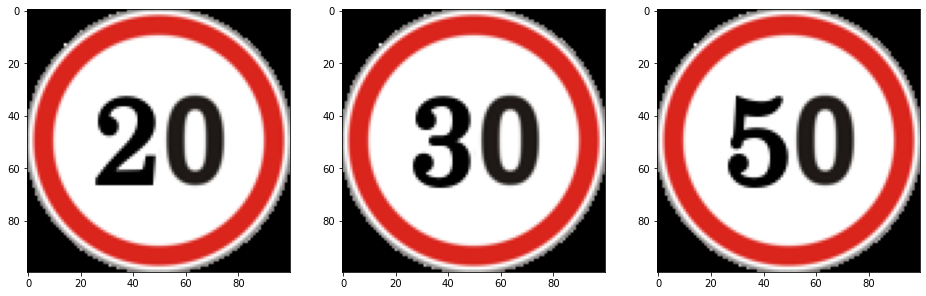

In [4]:
Meta_images = []
Meta_labels = []

plt.figure(figsize=(16,16))
for i in range(len(df_Meta)):
    img = load_img('./data/'+df_Meta['Path'][i])
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    Meta_images.append(img)
    Meta_labels.append(df_Meta['ClassId'][i])

### 1.2. 이미지 데이터 정보 파악하기 - Train

이번엔 `Train.csv`를 확인해 봅시다.

In [5]:
df_Train = pd.read_csv('./data/Train.csv')
df_Train

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,29,30,5,6,24,25,0,Train/0/00000_00000_00000.png
1,30,30,5,5,25,25,0,Train/0/00000_00000_00001.png
2,30,30,5,5,25,25,0,Train/0/00000_00000_00002.png
3,31,31,5,5,26,26,0,Train/0/00000_00000_00003.png
4,30,32,5,6,25,26,0,Train/0/00000_00000_00004.png
...,...,...,...,...,...,...,...,...
2665,50,51,6,6,45,46,2,Train/2/00002_00040_00025.png
2666,52,52,6,6,47,47,2,Train/2/00002_00040_00026.png
2667,55,55,6,6,50,50,2,Train/2/00002_00040_00027.png
2668,59,58,6,5,53,52,2,Train/2/00002_00040_00028.png


2670개의 학습용 이미지 데이터에 대한 정보가 저장되어 있음을 알 수 있습니다.

이러한 이미지 정보 중에 먼저 `Width`와 `Height`에 대해서 알아봅시다.

`Width`와 `Height` 정보는 이미지의 폭과 높이에 대한 정보로 간단히 샘플만 봐도 다양한 크기를 갖는 것을 알 수 있습니다.

이미지 크기가 모두 다르다면 이미지마다 서로 다른 feature의 개수가 있는 것이기에 이를 통일해주는 전 처리가 필요합니다.

그렇다면 어떤 크기로 통일을 해야 할까요? 이미지 크기의 분포를 보고 판단해봅시다.

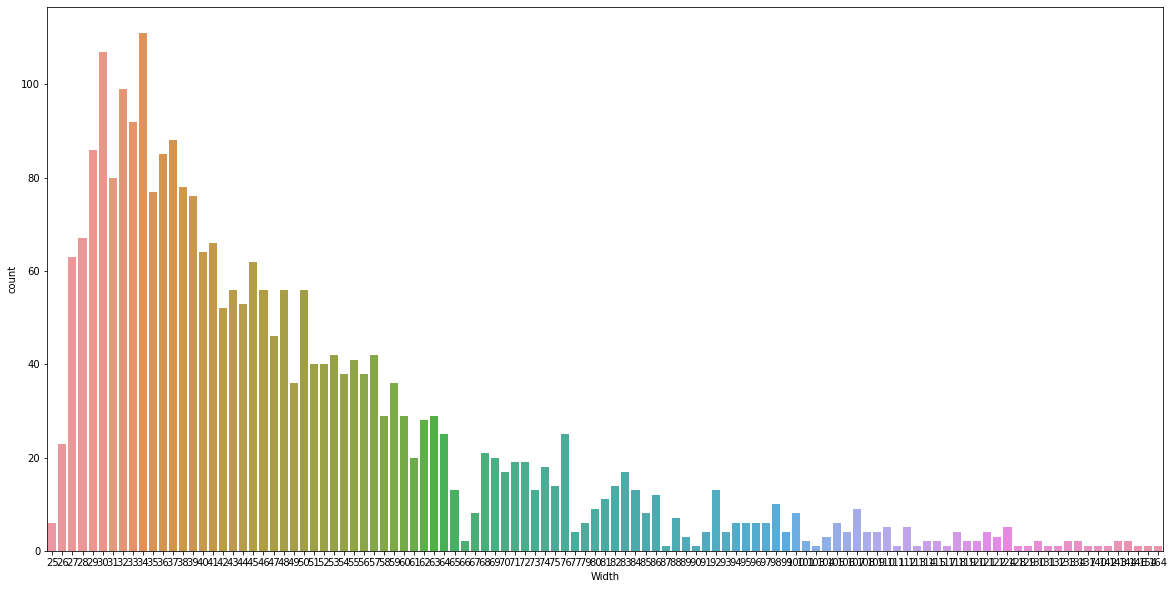

In [6]:
import seaborn as sns

plt.figure(figsize=(20,10))
ax = sns.countplot(x="Width", data=df_Train)

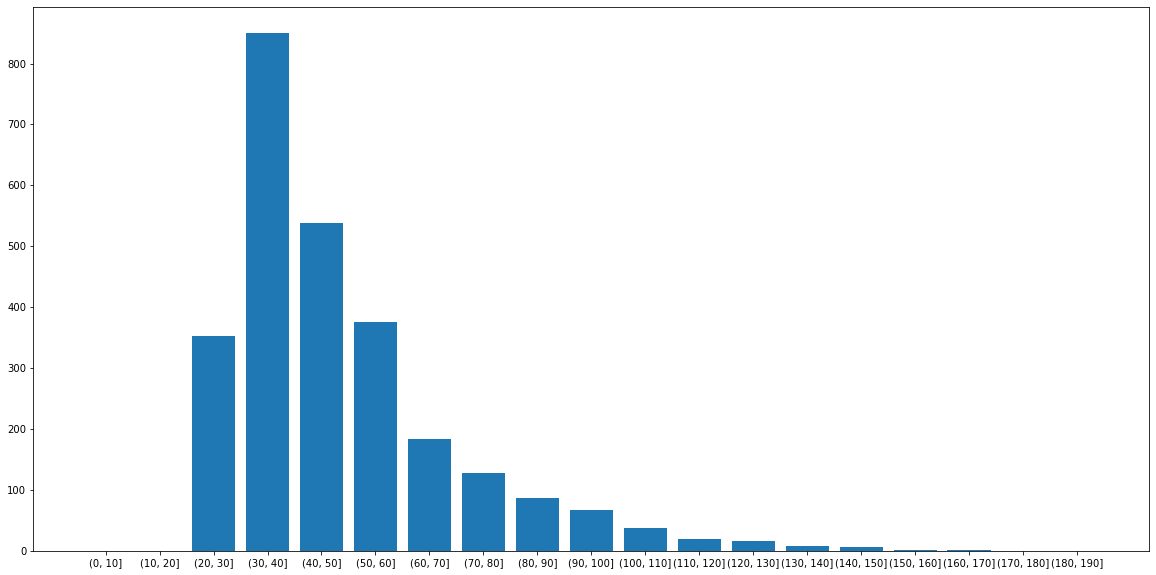

In [7]:
df_cutWidth = pd.cut(df_Train['Width'], np.arange(0,200,10)).value_counts(sort=False)

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(df_cutWidth)),df_cutWidth.values)
ax.set_xticks(range(len(df_cutWidth)))
ax.set_xticklabels(df_cutWidth.index)
fig.show()

위 분포를 보게 되면 30~35의 폭 또는 높이를 갖는 이미지가 제일 많음을 확인했습니다. 

이미지 크기를 통일하는 데 있어서 너무 작은 이미지는 큰 이미지의 정보 손실을 발생하며, 너무 큰 이미지는 작은 이미지의 정보 부족한 정보량을 부각할 것입니다. 

따라서 적절한 이미지 크기를 잡는 것은 하나의 파라미터 조정이 되며, 이번 프로젝트에서는 이미지 분포 기반으로 대다수를 차지하는 크기인 33x33 크기로 통일하겠습니다. (이후, 개인적인 실습에서 데이터 크기 조절에 따른 성능 변화를 살펴보는 것도 좋은 학습이 될 것입니다.)

In [8]:
image_height = 33
image_width = 33
image_channel = 3 # 컬러 이미지이기에 3채널

이번엔 Roi 데이터에 대해서 살펴봅시다. 이미지 데이터에서 Roi는 Region of interest의 약자로 지금 데이터에서는 표지판이 있는 부분을 의미합니다.

`Train.csv`, `Test.csv` 파일에 있는 Roi 데이터는 아래 실행된 이미지에서의 좌측 상단 좌표와 우측 하단 좌표를 의미합니다.

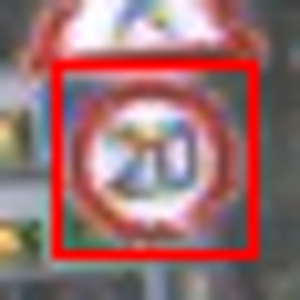

In [9]:
from PIL import Image
from PIL import ImageDraw

img_sample = Image.open('./data/'+df_Train['Path'][0])

draw = ImageDraw.Draw(img_sample)
draw.rectangle([df_Train['Roi.X1'][0], df_Train['Roi.Y1'][0], df_Train['Roi.X2'][0], df_Train['Roi.Y2'][0]], outline="red")
img_sample_resized = img_sample.resize((300,300))
img_sample_resized

Roi 데이터를 사용하면 보다 명확하게 표지판 부분만을 crop 할 수 있으며, 이러한 데이터 전 처리를 통하여 분류의 성능을 높일 수 있습니다. (이번 프로젝트에서는 해당 전 처리를 생략합니다.)

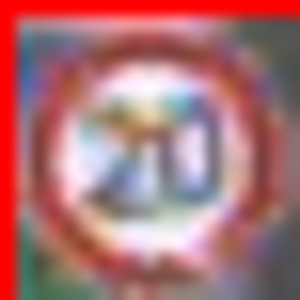

In [10]:
img_sample_crop = img_sample.crop((df_Train['Roi.X1'][0], df_Train['Roi.Y1'][0], df_Train['Roi.X2'][0], df_Train['Roi.Y2'][0]))
 
# Shows the image in image viewer
img_sample_crop_resized = img_sample_crop.resize((300,300))
img_sample_crop_resized

### 1.3. 이미지 데이터 정보 파악하기 - Test

이번엔 `Test.csv`를 살펴보겠습니다.

In [11]:
df_Test = pd.read_csv('./data/Test.csv')
df_Test

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,42,45,5,5,36,40,1,Test/00001.png
1,59,65,5,6,54,60,1,Test/00024.png
2,58,59,6,6,53,54,2,Test/00034.png
3,37,37,5,6,31,32,2,Test/00067.png
4,45,51,6,6,40,46,1,Test/00076.png
...,...,...,...,...,...,...,...,...
695,34,33,5,5,28,28,1,Test/05537.png
696,58,56,6,6,52,50,1,Test/05539.png
697,37,38,5,5,32,33,1,Test/05551.png
698,28,30,5,6,23,25,2,Test/05579.png


Train.csv와 같은 형태로 구성되어 있는 것을 알 수 있습니다. test 데이터에 대해서는 분석하는 것은 표지판을 분류 하는 목적에 있어 큰 의미가 있지 않기에 이번 실습에서는 생략합니다.

Roi 영역에 크기에 맞게 `df_Test['Path'][0]` 해당되는 이미지에 crop을 수행한 후 (300, 300) 해상도로 resize 합니다.

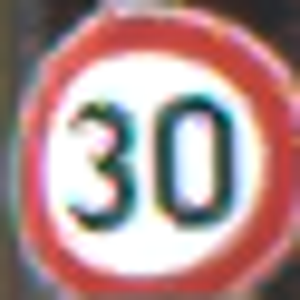

In [178]:
# crop함수를 활용하여 이미지를 잘라낼 수 있습니다.
# 이 후, resize함수를 활용하여 사이즈 변경을 수행합니다.

img_sample_test = Image.open('./data/'+df_Test['Path'][0])

img_sample_crop_test = img_sample_test.crop((df_Test['Roi.X1'][0], df_Test['Roi.Y1'][0], df_Test['Roi.X2'][0], df_Test['Roi.Y2'][0]))
img_sample_crop_resized_test = img_sample_crop_test.resize((300,300))
img_sample_crop_resized_test

## 2. 데이터 전 처리

### 2-1. 이미지 데이터 읽기

통일된 이미지 크기를 바탕으로 이미지를 읽어 보겠습니다.

먼저 학습용 이미지를 불러와 `Train_images`에 array 형태로 저장합니다.

In [12]:
image_height = 33
image_width = 33
image_channel = 3

Train_images = []
Train_labels = []

for i in tqdm(range(len(df_Train))):
    img = load_img('./data/'+df_Train['Path'][i], target_size = (image_height, image_width))
    img = img_to_array(img)
    Train_images.append(img)

100%|██████████| 2670/2670 [01:32<00:00, 28.90it/s]


같은 방식으로 평가용 이미지를 불러와 `Test_images`에 array 형태로 저장합니다.

In [13]:
Test_images = []
Test_labels = []

for i in tqdm(range(len(df_Test))):
    img = load_img('./data/'+df_Test['Path'][i], target_size = (image_height, image_width))
    img = img_to_array(img)
    Test_images.append(img)

100%|██████████| 700/700 [00:23<00:00, 29.25it/s]


### 2-2. label 데이터 읽기

학습용, 평가용 데이터에 대한 label은 csv 파일에 `ClassId` 열로 저장되어 있기에 이를 불러와 array로 저장합니다.

In [48]:
Train_labels = df_Train['ClassId'].values
Train_labels

array([0, 0, 0, ..., 2, 2, 2])

In [49]:
Test_labels = df_Test['ClassId'].values
Test_labels

array([1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2,
       1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 0,
       2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2,
       2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1,
       0, 2, 2, 2, 2, 1, 1, 2, 0, 0, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 1,
       2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 1, 1, 0, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2,
       1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 2, 2, 2,
       1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 2, 1, 1, 2, 2, 1, 2,
       1, 1, 2, 2, 2, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2,

### 2-3. 데이터 분리하기

딥러닝 학습 시, 과적합을 막기 위하여 validation 데이터를 학습용 데이터에서 분리합니다. 

모든 데이터는 numpy array로 저장합니다.

In [19]:
x_train, x_val, y_train, y_val = train_test_split(np.array(Train_images), np.array(Train_labels), test_size=0.4)

평가용 데이터도 적용합니다.

In [20]:
x_test = np.array(Test_images)
y_test = np.array(Test_labels)

In [21]:
x_train[0]

array([[[58., 53., 47.],
        [56., 51., 48.],
        [59., 53., 49.],
        ...,
        [81., 70., 66.],
        [74., 65., 62.],
        [66., 59., 56.]],

       [[56., 53., 49.],
        [54., 52., 52.],
        [61., 60., 55.],
        ...,
        [76., 70., 68.],
        [77., 70., 69.],
        [73., 64., 62.]],

       [[60., 58., 51.],
        [53., 54., 51.],
        [57., 61., 56.],
        ...,
        [69., 68., 65.],
        [81., 75., 72.],
        [71., 60., 57.]],

       ...,

       [[62., 61., 61.],
        [71., 65., 67.],
        [77., 65., 64.],
        ...,
        [63., 67., 64.],
        [65., 68., 63.],
        [71., 73., 70.]],

       [[66., 62., 60.],
        [76., 69., 67.],
        [72., 62., 59.],
        ...,
        [53., 63., 59.],
        [56., 63., 58.],
        [65., 70., 67.]],

       [[68., 63., 57.],
        [75., 68., 61.],
        [69., 59., 54.],
        ...,
        [52., 59., 55.],
        [56., 61., 56.],
        [57., 61., 57.]]

In [22]:
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

In [23]:
x_train[0]

array([[[0.22745098, 0.20784314, 0.18431373],
        [0.21960784, 0.2       , 0.1882353 ],
        [0.23137255, 0.20784314, 0.19215687],
        ...,
        [0.31764707, 0.27450982, 0.25882354],
        [0.2901961 , 0.25490198, 0.24313726],
        [0.25882354, 0.23137255, 0.21960784]],

       [[0.21960784, 0.20784314, 0.19215687],
        [0.21176471, 0.20392157, 0.20392157],
        [0.23921569, 0.23529412, 0.21568628],
        ...,
        [0.29803923, 0.27450982, 0.26666668],
        [0.3019608 , 0.27450982, 0.27058825],
        [0.28627452, 0.2509804 , 0.24313726]],

       [[0.23529412, 0.22745098, 0.2       ],
        [0.20784314, 0.21176471, 0.2       ],
        [0.22352941, 0.23921569, 0.21960784],
        ...,
        [0.27058825, 0.26666668, 0.25490198],
        [0.31764707, 0.29411766, 0.28235295],
        [0.2784314 , 0.23529412, 0.22352941]],

       ...,

       [[0.24313726, 0.23921569, 0.23921569],
        [0.2784314 , 0.25490198, 0.2627451 ],
        [0.3019608 , 0

---

### 이미지 crop 처리 및 전 처리

이미지의 roi 영역을 crop 하고 `Train_images`, `Test_images`에 저장합니다.

In [36]:
from PIL import Image
from PIL import ImageDraw

image_height = 33
image_width = 33
image_channel = 3

Train_images = []



for i in tqdm(range(len(df_Train))):
    img_sample = Image.open('./data/'+df_Train['Path'][i])

    img_sample_crop = img_sample.crop((df_Train['Roi.X1'][i], df_Train['Roi.Y1'][i], df_Train['Roi.X2'][i], df_Train['Roi.Y2'][i]))
    img_sample_crop_resized = img_sample_crop.resize((image_height,image_width))

    img = img_to_array(img_sample_crop_resized).reshape(image_height, image_width, image_channel)
    Train_images.append(img)

100%|██████████| 2670/2670 [01:24<00:00, 31.71it/s]


In [37]:
Test_images = []

for i in tqdm(range(len(df_Test))):
    img_sample = Image.open('./data/'+df_Test['Path'][i])

    img_sample_crop = img_sample.crop((df_Test['Roi.X1'][i], df_Test['Roi.Y1'][i], df_Test['Roi.X2'][i], df_Test['Roi.Y2'][i]))
    img_sample_crop_resized = img_sample_crop.resize((image_height,image_width))

    img = img_to_array(img_sample_crop_resized).reshape(image_height, image_width, image_channel)
    Test_images.append(img)

100%|██████████| 700/700 [00:21<00:00, 32.58it/s]


---

### Data augmentation

Tensorflow의 `ImageDataGenerator()`을 사용하여 Data augmentation을 수행해보겠습니다.

우선 datagen에 `ImageDataGenerator()` 하이퍼파라미터를 설정하고 초기화합니다.

In [42]:
datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #horizontal_flip=True,
    #validation_split=0.2
    )

기존 데이터가 섞여 있지 않기에 `flow` 메서드 사용시 에러가 출력됩니다.

이를 해결하기 위해여 sklearn의 `shuffle` 함수를 사용합니다.

In [46]:
np.array(Train_images).shape

(2670, 33, 33, 3)

In [50]:
Train_labels

array([0, 0, 0, ..., 2, 2, 2])

In [51]:
from sklearn.utils import shuffle

Train_images, Train_labels = shuffle(np.array(Train_images), Train_labels, random_state=0)

데이터를 섞고 준비한 이미지 데이터를 넣어서 새로운 이미지 데이터를 생성합니다.

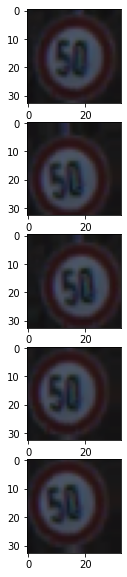

In [52]:
gen = datagen.flow(Train_images, Train_labels, batch_size=1)# , subset='training'
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,1,i+1)
    batch = gen.__getitem__(0)
    img = batch[0].astype('uint8')
    plt.imshow(img[0])
plt.show()

`Train_images`의 크기만큼 증강된 이미지를 추가하여 `Train_images_aug`에 저장합니다.

In [53]:
Train_images_aug = Train_images
Train_labels_aug = Train_labels

for i in tqdm(range(gen.__len__())):
    batch = gen.__getitem__(i)
    img_aug = batch[0].astype('uint8')
    label_aug = batch[1]
    Train_images_aug = np.append(Train_images_aug,img_aug, axis=0)
    Train_labels_aug = np.append(Train_labels_aug,label_aug, axis=0)


100%|██████████| 2670/2670 [00:29<00:00, 91.67it/s]


In [54]:
Train_images_aug.shape

(5340, 33, 33, 3)

In [55]:
Train_labels_aug.shape

(5340,)

validation data를 사용하기 위하여 `Train_images_aug` 데이터를 분리합니다.

In [56]:
x_train_aug, x_val_aug, y_train_aug, y_val_aug = train_test_split(Train_images_aug, Train_labels_aug, test_size=0.2)

In [57]:
x_train_aug, x_val_aug = x_train_aug / 255.0, x_val_aug / 255.0

## 3. 딥러닝 모델

### 3-1. CNN 모델 설정

CNN을 사용하여 간단하게 모델을 구현해 보겠습니다. filters, kernel 등의 사이즈는 하이퍼 파리미터로 자신만의 모델로 튜닝이 가능합니다.

In [38]:
model = Sequential([    
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(image_height, image_width, image_channel)),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.25),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.25),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 31, 31, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

증강 데이터를 학습할 모델을 `model_aug`으로 설정합니다.

In [58]:
model_aug = Sequential([    
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(image_height, image_width, image_channel)),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.25),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.25),
    Dense(3, activation='softmax')
])

model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 31, 31, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)             

### 3-2. 학습 수행

3개의 class를 갖는 데이터이기에 loss 함수로 `sparse_categorical_crossentropy`을 설정하고 optimizer로는 adam을 사용하여 학습하여 보겠습니다.

In [39]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

마찬가지로 `model_aug`을 위한 compile을 설정하고 학습합니다.

In [59]:
model_aug.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [40]:
# 처음 만든 모델이라면 EPOCHS를 1~5개로 하여 잘 돌아가는지 성능을 확인해보고 값을 증가 시켜 봅시다. 
EPOCHS = 30

# EPOCHS에 따른 성능을 보기 위하여 history 사용
history = model.fit(x_train, 
                    y_train,
                    validation_data = (x_val, y_val), # validation 데이터 사용
                    epochs=EPOCHS, 
                   )

Epoch 1/30
51/51 [==============================] - 3s 60ms/step - loss: 0.9867 - accuracy: 0.5076 - val_loss: 0.8790 - val_accuracy: 0.5805
Epoch 2/30
51/51 [==============================] - 3s 57ms/step - loss: 0.8041 - accuracy: 0.6384 - val_loss: 0.6275 - val_accuracy: 0.7669
Epoch 3/30
51/51 [==============================] - 3s 58ms/step - loss: 0.5452 - accuracy: 0.7694 - val_loss: 0.3337 - val_accuracy: 0.8970
Epoch 4/30
51/51 [==============================] - 3s 57ms/step - loss: 0.3053 - accuracy: 0.8797 - val_loss: 0.2418 - val_accuracy: 0.9007
Epoch 5/30
51/51 [==============================] - 3s 56ms/step - loss: 0.2139 - accuracy: 0.9150 - val_loss: 0.1655 - val_accuracy: 0.9354
Epoch 6/30
51/51 [==============================] - 3s 58ms/step - loss: 0.2240 - accuracy: 0.9074 - val_loss: 0.1099 - val_accuracy: 0.9738
Epoch 7/30
51/51 [==============================] - 3s 58ms/step - loss: 0.1042 - accuracy: 0.9687 - val_loss: 0.0713 - val_accuracy: 0.9822
Epoch 8/30
51

In [60]:
# 처음 만든 모델이라면 EPOCHS를 1~5개로 하여 잘 돌아가는지 성능을 확인해보고 값을 증가 시켜 봅시다. 
EPOCHS = 30

# EPOCHS에 따른 성능을 보기 위하여 history 사용
history2 = model_aug.fit(x_train_aug, 
                    y_train_aug,
                    validation_data = (x_val_aug, y_val_aug), # validation 데이터 사용
                    epochs=EPOCHS, 
                   )

Epoch 1/30
134/134 [==============================] - 8s 54ms/step - loss: 0.9099 - accuracy: 0.5405 - val_loss: 0.5356 - val_accuracy: 0.8015
Epoch 2/30
134/134 [==============================] - 7s 53ms/step - loss: 0.4084 - accuracy: 0.8268 - val_loss: 0.1857 - val_accuracy: 0.9242
Epoch 3/30
134/134 [==============================] - 7s 53ms/step - loss: 0.1921 - accuracy: 0.9314 - val_loss: 0.0801 - val_accuracy: 0.9719
Epoch 4/30
134/134 [==============================] - 7s 53ms/step - loss: 0.1110 - accuracy: 0.9578 - val_loss: 0.0437 - val_accuracy: 0.9869
Epoch 5/30
134/134 [==============================] - 7s 53ms/step - loss: 0.0667 - accuracy: 0.9791 - val_loss: 0.0429 - val_accuracy: 0.9906
Epoch 6/30
134/134 [==============================] - 7s 53ms/step - loss: 0.0470 - accuracy: 0.9862 - val_loss: 0.0367 - val_accuracy: 0.9897
Epoch 7/30
134/134 [==============================] - 7s 53ms/step - loss: 0.0424 - accuracy: 0.9852 - val_loss: 0.0241 - val_accuracy: 0.9906

학습을 수행하면서 Accuracy와 Loss의 변화를 그래프로 출력하면 다음과 같습니다.

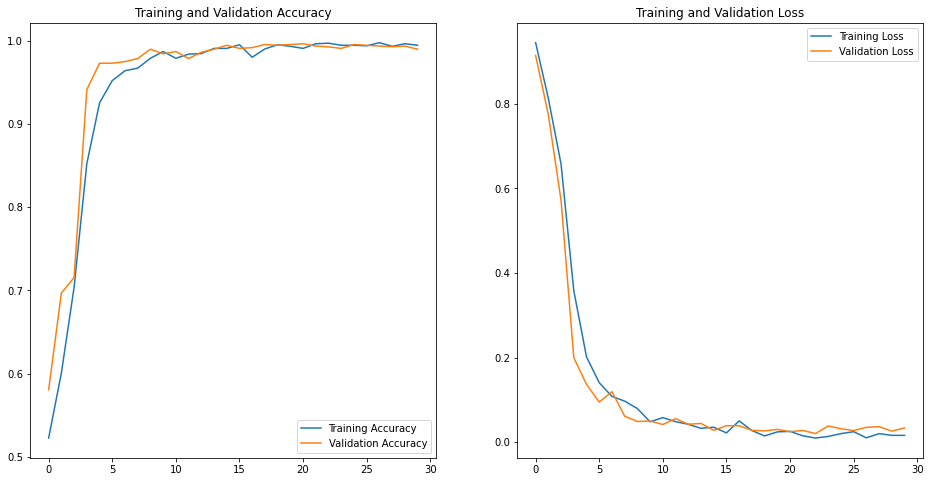

In [27]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

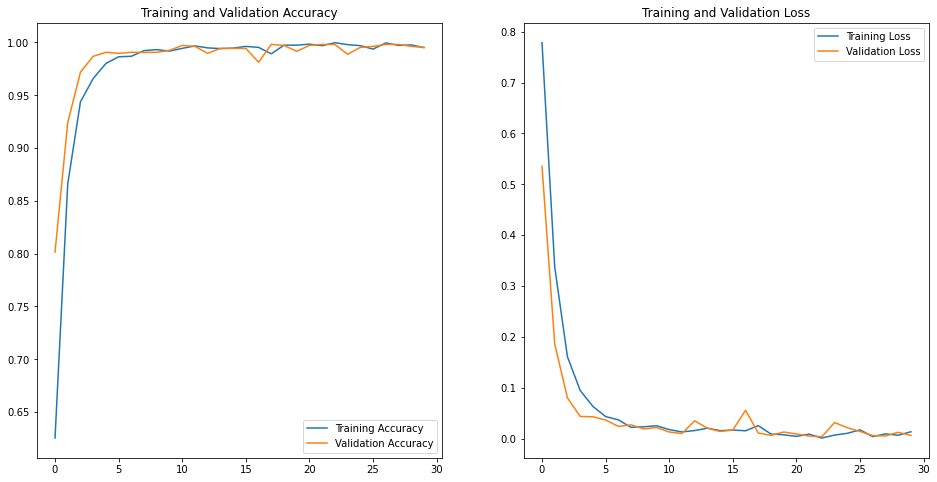

In [61]:
accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']

loss2=history2.history['loss']
val_loss2=history2.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy2, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

---

## 전이 학습(Transfer learning)

InceptionV3 모델을 사용하는 전이 학습에 대해서 수행합니다.

먼저 미리 학습된 InceptionV3 모델의 weight가 저장된 파일을 다운받습니다. (https://codetorial.net/tensorflow/transfer_learning.html 코드)

In [62]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
  -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-10-29 09:40:34--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.196.112, 142.250.196.144, 142.251.42.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.196.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  38.9MB/s    in 2.2s    

2021-10-29 09:40:36 (38.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [78]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                              include_top=False,
                              weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [79]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [80]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(3, activation='softmax')(x)

model_InceptionV3 = Model(pre_trained_model.input, x)

model_InceptionV3.compile(optimizer='adam',
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

model_InceptionV3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

---

### 3-3. 모델 성능 평가 및 예측

학습이 잘 수행 되었으면 평가용 데이터에서 성능이 잘 나오는 확인합니다.

In [28]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

print('test set accuracy: ', test_accuracy)

test set accuracy:  0.9457142949104309


이번엔 테스트 데이터를 입력하여 예측된 결과를 비교해 보겠습니다.

25개의 테스트 데이터를 불러와 실제 class와 예측 class를 출력하면 다음과 같습니다.

In [34]:
test_prediction = np.argmax(model.predict(x_test), axis=-1)

In [32]:
model.predict(x_test)

array([[4.3902178e-13, 1.0000000e+00, 7.9774766e-15],
       [6.1836576e-13, 9.9999988e-01, 8.6405912e-08],
       [3.4460382e-29, 1.9830434e-20, 1.0000000e+00],
       ...,
       [7.6326941e-08, 9.9999714e-01, 2.6904841e-06],
       [1.6925765e-06, 1.6103777e-03, 9.9838793e-01],
       [6.4916947e-11, 1.0000000e+00, 1.8275383e-08]], dtype=float32)

In [33]:
model.predict(x_test).shape

(700, 3)

In [35]:
test_prediction

array([1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1,
       2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,
       2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1,
       1, 2, 2, 2, 2, 1, 2, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 1,
       2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 1, 1, 0, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2,
       1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2,
       1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2,
       1, 1, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1,

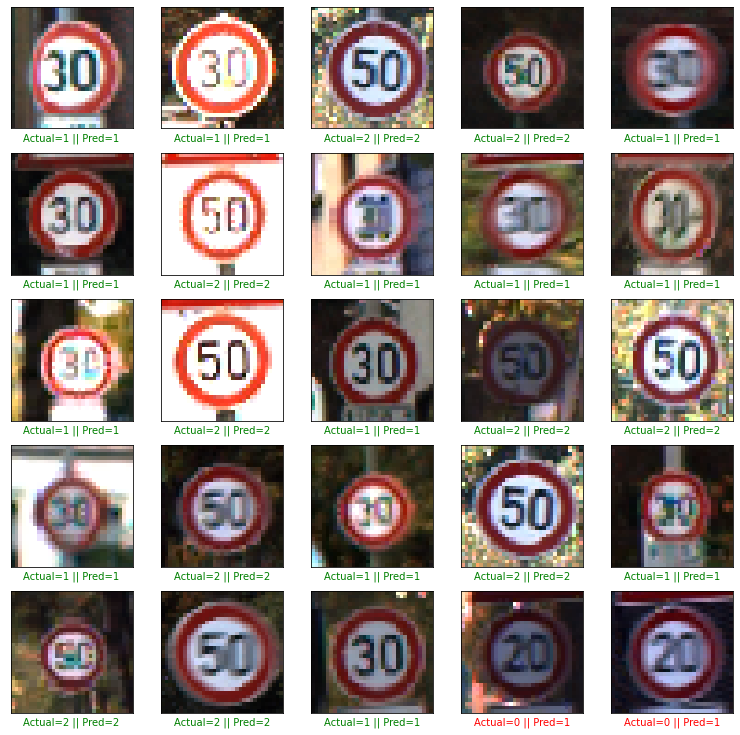

In [30]:
plt.figure(figsize = (13, 13))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = test_prediction[start_index + i]
    actual = y_test[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(array_to_img(x_test[start_index + i]))
plt.show()

마지막으로 confusion matrix를 시각화 하여 분류 학습 결과를 확인해봅니다.

<AxesSubplot:>

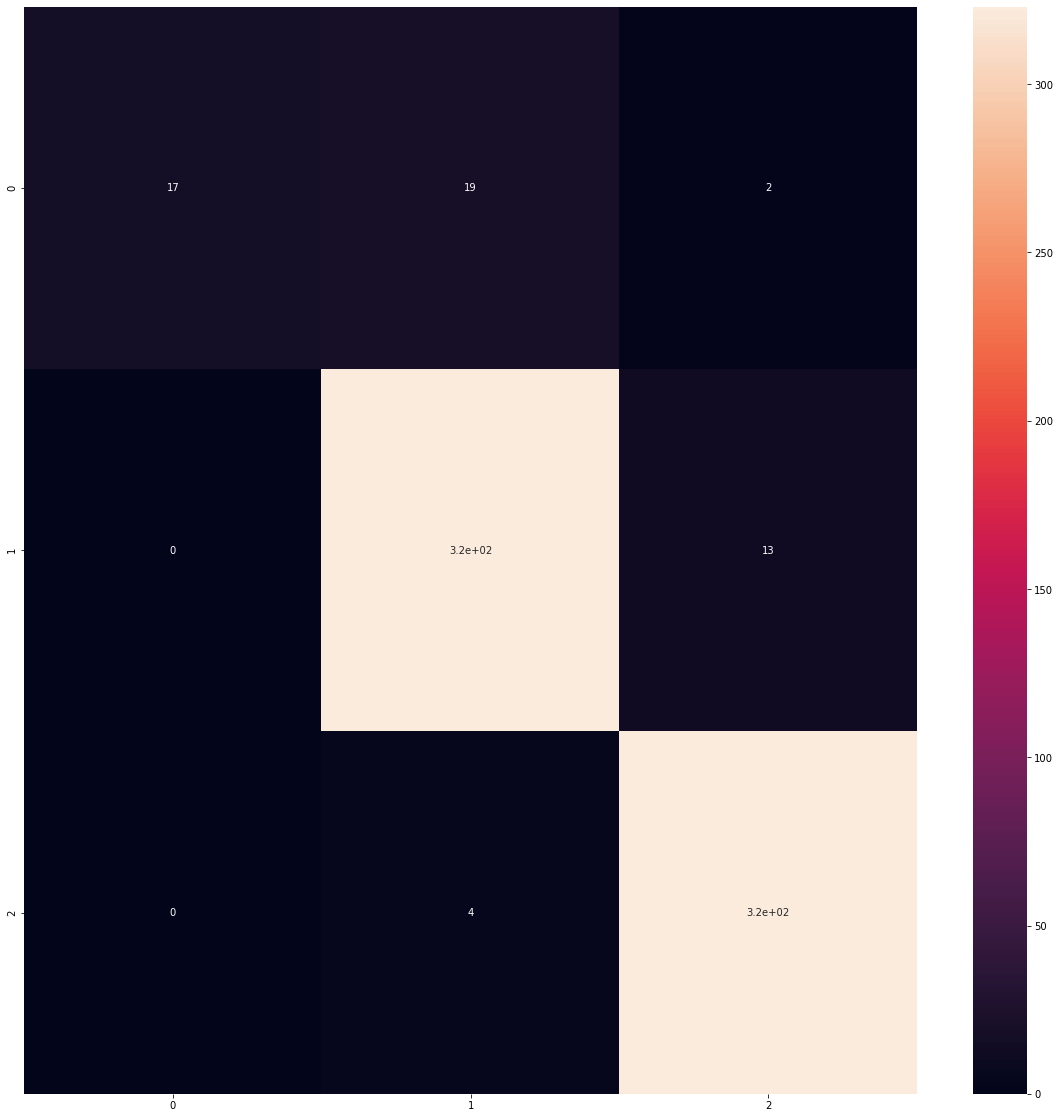

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_prediction)
plt.figure(figsize = (20, 20))
sns.heatmap(cm, annot = True)

위 학습한 CNN 모델에서 학습용 데이터(`x_train, y_train`)의 confusion matrix를 구합니다.

In [174]:
# CNN 모델의 x_train에 대한 예측값을 구하고 confusion_matrix() 를 사용하면 confusion matrix를 구할 수 있습니다.

train_prediction = np.argmax(model.predict(x_train), axis=-1)
cm_train = confusion_matrix(y_train, train_prediction)
cm_train

array([[134,   0,   0],
       [  0, 727,   0],
       [  0,   0, 741]])

In [175]:
cm_train.sum()

1602

In [176]:
np.trace(cm_train)/cm_train.sum()

1.0